Sensores de iluminación, ruido, temperatura, viento
Se le daban recomendaciones
Monitoreamos el sueño y los signos vitales
BF = breath frequency, es mejor entre mas pequeña
DS = seep sleep, entre mayor mejor
HR = hearth rate, entre menor mejor
HRV = indicador de estréz, entre mayor mejor
OS = oxigenacion, entre mayor es mejor
REMS = sueño rem, entre mayor es mejor
S = snooring, entre menor mejor
T = temperatura, entre menor es mejor
TST = total sleep time, entre mayor es mejor

la dif entre los C y los S, C es con la red de sensores y con el sistema de recomendaciones, S sin la red de sensores 

no hay métricas mas importntes de otras

Descubir:
!- si la red de sensores ayudó a los pacientes de manera significativa
2- Como se pude predecir si la red de sensores la va a ayudar o no a dormir mejor

In [40]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score,confusion_matrix
from sklearn import tree


In [14]:
ruta_archivos = './data'

dfs = []

for archivo in os.listdir(ruta_archivos):
    if archivo.endswith('.txt'):
        ruta_completa = os.path.join(ruta_archivos, archivo)
        
        df_temp = pd.read_csv(ruta_completa, header=None, names=[archivo[:-4]], skiprows=1)
        
        dfs.append(df_temp)

df = pd.concat(dfs, axis=1)

print(df)

    OS_s  OS_c  BF_c  HRV_c  BF_s  HRV_s  HR_s   T_s  HR_c   T_c  TST_c   
0     98    96    12     21    18     16    95  37.2    67  36.9      8  \
1     95    98    16     17    16      9    99  36.9    87  36.9      6   
2     98    94    12     19    19      7    68  37.4    72  37.1      7   
3     96    99    12     16    17     10   100  37.3    79  36.7      7   
4     95    92    15     17    16     13    86  37.5    67  36.7      9   
..   ...   ...   ...    ...   ...    ...   ...   ...   ...   ...    ...   
95    91    92    12     15    14     11    61  37.2    62  36.8      7   
96    94    93    15     17    21      7    83  37.6    61  36.6      8   
97    95    99    14     19    19     11    78  37.6    78  36.8      9   
98    89    99    13     19    19     11    56  37.1    68  36.6      9   
99    92    99    13     22    24     11    72  37.4    71  36.5      9   

    REMS_s  S_c  DS_s  S_s  TST_s  REMS_c  DS_c  
0       22    9    12    9      6      24    14  

# Análisis Exploratorio de Datos (EDA)

In [15]:
# Análisis Estadístico
for columna in ['BF', 'DS', 'HR', 'HRV', 'OS', 'REMS', 'S', 'T', 'TST']:
    stat, p_value = ttest_rel(df[columna + '_c'], df[columna + '_s'])
    print(f'{columna}: p-value = {p_value}')

BF: p-value = 7.785776307326507e-09
DS: p-value = 4.91545251062185e-05
HR: p-value = 0.005523230847361244
HRV: p-value = 3.494997684686937e-28
OS: p-value = 0.0015274985461873364
REMS: p-value = 4.015763704659905e-18
S: p-value = 3.365849796110103e-09
T: p-value = 7.653771758549726e-23
TST: p-value = 7.884992636666052e-23


Un p-value < 0.05 indica una diferencia significativa

In [19]:
medias = df.mean()
medias

OS_s      93.990
OS_c      95.230
BF_c      14.590
HRV_c     15.980
BF_s      16.780
HRV_s      9.920
HR_s      81.140
T_s       37.319
HR_c      75.820
T_c       36.812
TST_c      7.200
REMS_s    19.640
S_c        5.620
DS_s      13.110
S_s        8.470
TST_s      5.770
REMS_c    22.530
DS_c      15.240
dtype: float64

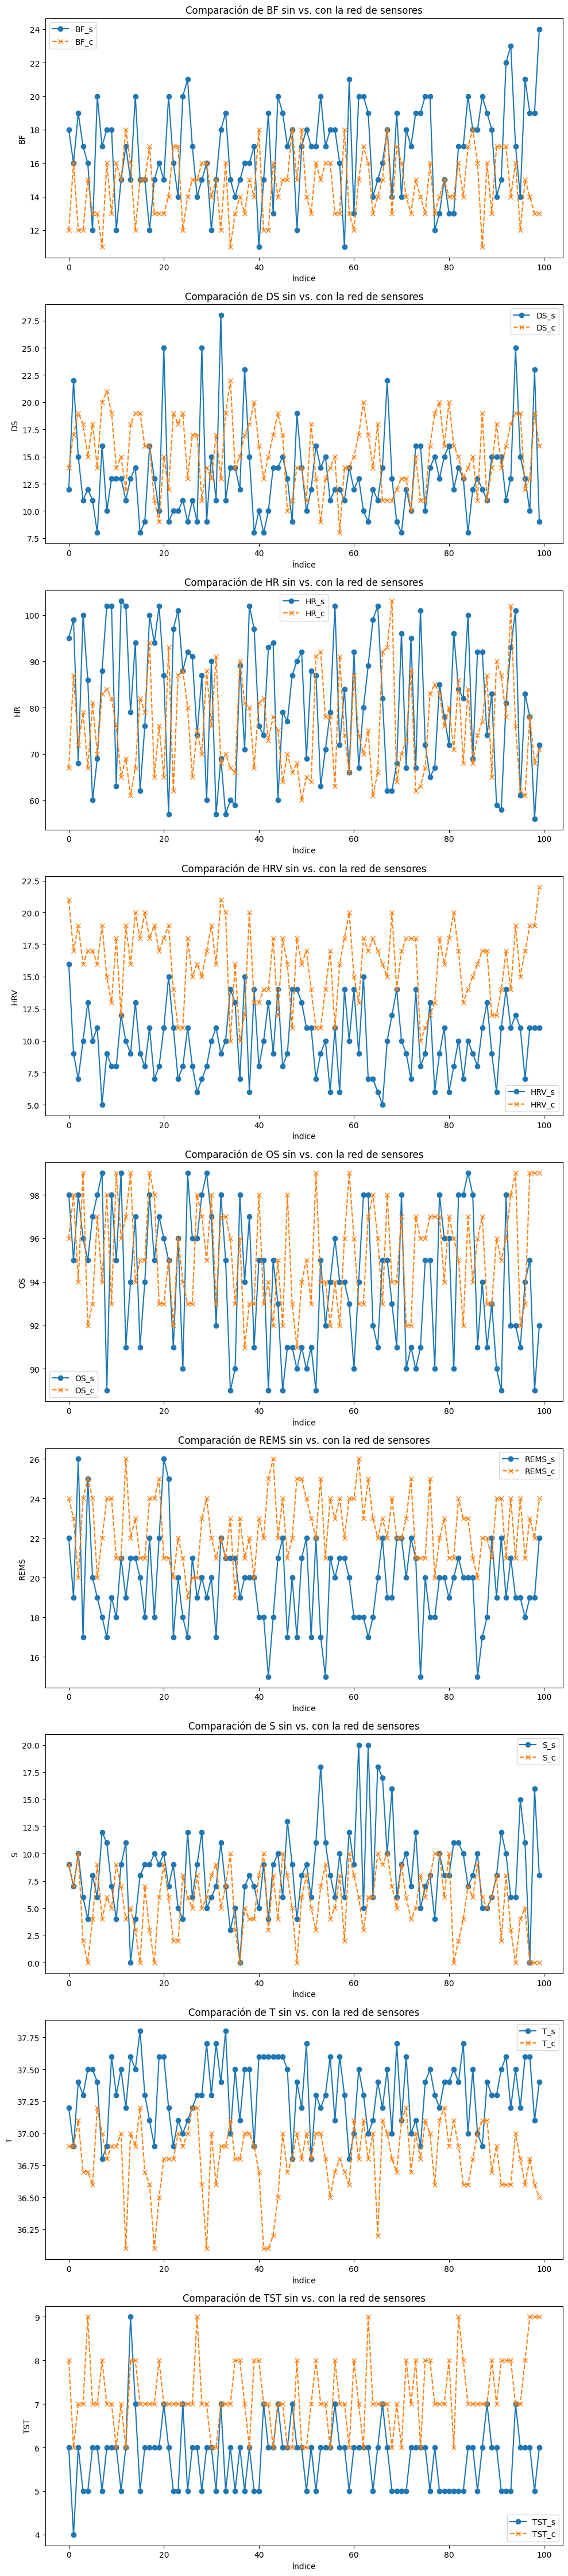

In [18]:
variables = ['BF', 'DS', 'HR', 'HRV', 'OS', 'REMS', 'S', 'T', 'TST']

n_vars = len(variables)
fig, axes = plt.subplots(n_vars, 1, figsize=(10, 5 * n_vars))

if n_vars == 1:
    axes = [axes]

for i, var in enumerate(variables):
    index = np.arange(len(df))
    axes[i].plot(index, df[var + '_s'], label=f'{var}_s', marker='o', linestyle='-')
    axes[i].plot(index, df[var + '_c'], label=f'{var}_c', marker='x', linestyle='--')
    axes[i].set_title(f'Comparación de {var} sin vs. con la red de sensores')
    axes[i].set_xlabel('Índice')
    axes[i].set_ylabel(var)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [20]:
mejoras = {
    'BF': 'menor',   # Mejor cuando es menor
    'DS': 'mayor',   # Mejor cuando es mayor
    'HR': 'menor',   # Mejor cuando es menor
    'HRV': 'mayor',  # Mejor cuando es mayor
    'OS': 'mayor',   # Mejor cuando es mayor
    'REMS': 'mayor', # Mejor cuando es mayor
    'S': 'menor',    # Mejor cuando es menor
    'T': 'menor',    # Mejor cuando es menor
    'TST': 'mayor'   # Mejor cuando es mayor
}

resultados = {}

for indicador, criterio in mejoras.items():
    s_media = medias[indicador + '_s']
    c_media = medias[indicador + '_c']
    if criterio == 'menor':
        resultados[indicador] = '_c es mejor' if c_media < s_media else '_s es mejor'
    else: # criterio == 'mayor'
        resultados[indicador] = '_c es mejor' if c_media > s_media else '_s es mejor'

resultados

{'BF': '_c es mejor',
 'DS': '_c es mejor',
 'HR': '_c es mejor',
 'HRV': '_c es mejor',
 'OS': '_c es mejor',
 'REMS': '_c es mejor',
 'S': '_c es mejor',
 'T': '_c es mejor',
 'TST': '_c es mejor'}

# Que tanto mejoran con las recomendaciones

In [21]:
mejoras = {}

# Para variables donde menor es mejor (BF, HR, S, T), usamos: ((s - c) / s) * 100
mejoras['BF'] = ((medias['BF_s'] - medias['BF_c']) / medias['BF_s']) * 100
mejoras['HR'] = ((medias['HR_s'] - medias['HR_c']) / medias['HR_s']) * 100
mejoras['S'] = ((medias['S_s'] - medias['S_c']) / medias['S_s']) * 100
mejoras['T'] = ((medias['T_s'] - medias['T_c']) / medias['T_s']) * 100

# Para variables donde mayor es mejor (DS, HRV, OS, REMS, TST), usamos: ((c - s) / s) * 100
mejoras['DS'] = ((medias['DS_c'] - medias['DS_s']) / medias['DS_s']) * 100
mejoras['HRV'] = ((medias['HRV_c'] - medias['HRV_s']) / medias['HRV_s']) * 100
mejoras['OS'] = ((medias['OS_c'] - medias['OS_s']) / medias['OS_s']) * 100
mejoras['REMS'] = ((medias['REMS_c'] - medias['REMS_s']) / medias['REMS_s']) * 100
mejoras['TST'] = ((medias['TST_c'] - medias['TST_s']) / medias['TST_s']) * 100

mejoras

{'BF': 13.051251489868898,
 'HR': 6.556568893270899,
 'S': 33.64817001180638,
 'T': 1.3585573032503497,
 'DS': 16.247139588100694,
 'HRV': 61.08870967741936,
 'OS': 1.319289286094275,
 'REMS': 14.714867617107947,
 'TST': 24.783362218370897}

In [22]:
def porcentaje_mejoras_registro(row):
    total_variables = len(variables)
    mejoras = 0
    for var in variables:
        if var in ['BF', 'HR', 'S', 'T']:  # Menor es mejor
            if row[var + '_c'] < row[var + '_s']:
                mejoras += 1
        else:  # Mayor es mejor
            if row[var + '_c'] > row[var + '_s']:
                mejoras += 1
    porcentaje_mejoras = (mejoras / total_variables) * 100
    return porcentaje_mejoras

porcentajes_mejoras = df.apply(porcentaje_mejoras_registro, axis=1)

rangos = {
    '0-25%': 0,
    '25-49.9%': 0,
    '50-74.9%': 0,
    '75-100%': 0
}

for porcentaje in porcentajes_mejoras:
    if porcentaje <= 25:
        rangos['0-25%'] += 1
    elif porcentaje <= 49.9:
        rangos['25-49.9%'] += 1
    elif porcentaje <= 74.9:
        rangos['50-74.9%'] += 1
    else:
        rangos['75-100%'] += 1

rangos


{'0-25%': 0, '25-49.9%': 1, '50-74.9%': 42, '75-100%': 57}

# Como saber si la red de sensores le ayudará a dormir mejor o no

In [24]:
# Una mejora se define como cualquier aumento en TST, DS, o REMS cuando se utiliza la red de sensores
df['mejora_calidad_sueno'] = ((df['TST_c'] > df['TST_s']) | (df['DS_c'] > df['DS_s']) | (df['REMS_c'] > df['REMS_s'])).astype(int)

In [29]:
X = df[[var + '_s' for var in variables]] 
y = df['mejora_calidad_sueno']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

modelo = RandomForestClassifier(random_state=42)
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'AUC: {roc_auc_score(y_test, y_pred)}')

Accuracy: 1.0


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [31]:
df['mejora_TST'] = (df['TST_c'] > df['TST_s']).astype(int)
df['mejora_REM'] = (df['REMS_c'] > df['REMS_s']).astype(int)
df['mejora_DS'] = (df['DS_c'] > df['DS_s']).astype(int)

conteo_mejoras = {
    'mejora_TST': df['mejora_TST'].sum(),
    'mejora_REM': df['mejora_REM'].sum(),
    'mejora_DS': df['mejora_DS'].sum()
}

conteo_mejoras

{'mejora_TST': 80, 'mejora_REM': 85, 'mejora_DS': 68}

In [35]:
X = df[[var + '_s' for var in variables]] 
y = df['mejora_TST']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo = RandomForestClassifier(random_state=42)
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.85
[[ 1  3]
 [ 0 16]]


### Primera fila [1 3]: Esta fila representa las instancias reales de la clase negativa (en este contexto, los casos en que no hubo mejora en TST).

* 1 es el número de verdaderos negativos (TN): casos en los que el modelo predijo correctamente que no habría mejora en TST.
* 3 es el número de falsos positivos (FP): casos en los que el modelo predijo incorrectamente que habría una mejora en TST.

### Segunda fila [0 16]: Esta fila representa las instancias reales de la clase positiva (casos en que sí hubo mejora en TST).

* 0 es el número de falsos negativos (FN): casos en los que el modelo predijo incorrectamente que no habría mejora en TST.
* 16 es el número de verdaderos positivos (TP): casos en los que el modelo predijo correctamente que habría una mejora en TST.

In [37]:
def solicitar_datos_usuario(variables):
    datos_usuario = {}
    print("Por favor, ingresa los siguientes datos:")
    for var in variables:
        datos_usuario[var] = float(input(f"{var}: "))
    return datos_usuario

def predecir_mejora_sueno(modelo_rf, datos_usuario, variables):
    df_usuario = pd.DataFrame([datos_usuario], columns=variables)
    prediccion = modelo_rf.predict(df_usuario)
    return prediccion[0]

variables = ['BF_s','DS_s','HR_s','HRV_s','OS_s','REMS_s','S_s','T_s','TST_s']

datos_usuario = solicitar_datos_usuario(variables)

mejora_sueno = predecir_mejora_sueno(modelo, datos_usuario, variables)

if mejora_sueno == 1:
    print("Según el modelo, es probable que tu sueño mejore.")
else:
    print("Según el modelo, es posible que tu sueño no mejore significativamente.")

Por favor, ingresa los siguientes datos:
Según el modelo, es probable que tu sueño mejore.


Tarea

normalizar todas  las metricas, y generar una variable objetivo para todas estas metricas viendo si las variables están normalmente distribuidas o no con una regresion logistica

In [ ]:
co